# How to deal with boundary conditions

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pl
import hazel

/scratch/miniconda3.7/envs/hazel/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject
  return f(*args, **kwds)


All profiles in Hazel are assumed to be normalized to the quiet Sun at disk center. Let's do a few experiments to get a grasp at how profiles depend on the observing conditions. To facilitate things, let us wrap the experiments in a function that we can call with different parameters.

In [2]:
def synthesize(theta, boundaryI=1.0):

    thetaB = 0.0
    phiB = 0.0

    # Test a photosphere
    mod = hazel.Model(working_mode='synthesis')
    mod.add_spectral({'Name': 'spec1', 'Wavelength': [10826, 10835, 150], 'topology': 'ph1', 
                      'LOS': [theta,0.0,90.0], 'Boundary condition': [boundaryI,0.0,0.0,0.0]})
    mod.add_photosphere({'Name': 'ph1', 'Spectral region': 'spec1', 'Spectral lines': [300], 
                         'Wavelength': [10826, 10835], 'Reference atmospheric model': 'photospheres/init_spot.1d'})
    mod.setup()
    mod.synthesize()

    f, ax = pl.subplots()
    ax.plot(mod.spectrum['spec1'].wavelength_axis, mod.spectrum['spec1'].stokes[0,:])

    # Test a chromosphere
    mod = hazel.Model(working_mode='synthesis')
    mod.add_spectral({'Name': 'spec1', 'Wavelength': [10826, 10835, 150], 'topology': 'ch1', 
                      'LOS': [theta,0.0,90.0], 'Boundary condition': [boundaryI,0.0,0.0,0.0]})
    mod.add_chromosphere({'Name': 'ch1', 'Spectral region': 'spec1', 'Height': 3.0, 'Line': '10830', 
                          'Wavelength': [10826, 10835], 'Reference frame': 'line-of-sight'})
    mod.setup()


    mod.atmospheres['ch1'].set_parameters([0.0, 0.0, 0.0,1.0,0.0,8.0,1.0,0.0],1.0)
    mod.synthesize()

    ax.plot(mod.spectrum['spec1'].wavelength_axis, mod.spectrum['spec1'].stokes[0,:])

    # Test a photosphere+chromosphere
    mod = hazel.Model(working_mode='synthesis')
    mod.add_spectral({'Name': 'spec1', 'Wavelength': [10826, 10835, 150], 'topology': 'ph1->ch1', 
                      'LOS': [theta,0.0,90.0], 'Boundary condition': [boundaryI,0.0,0.0,0.0]})
    mod.add_photosphere({'Name': 'ph1', 'Spectral region': 'spec1', 'Spectral lines': [300], 
                         'Wavelength': [10826, 10835], 'Reference atmospheric model': 'photospheres/init_spot.1d'})
    mod.add_chromosphere({'Name': 'ch1', 'Spectral region': 'spec1', 'Height': 3.0, 'Line': '10830', 
                          'Wavelength': [10826, 10835], 'Reference frame': 'line-of-sight'})
    mod.setup()

    mod.atmospheres['ch1'].set_parameters([0.0, 0.0, 0.0,1.0,0.0,8.0,1.0,0.0],1.0)
    mod.synthesize()


    ax.plot(mod.spectrum['spec1'].wavelength_axis, mod.spectrum['spec1'].stokes[0,:])

## Disk center
Let us assume that we are at disk center and synthesize the profile emerging from a photosphere, a chromosphere and the combination of the two:

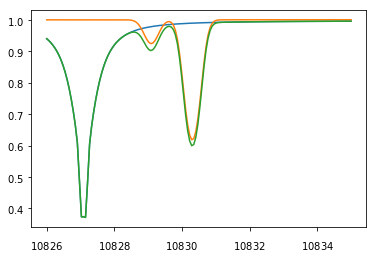

In [3]:
synthesize(theta=0.0)

As you can see, the emergent profiles are normalized to one, as one would expect for a disk center observation. For such an observation, in inversion mode, the observed profiles should be then normalized to unit continuum because we are placed at disk center.

When a photosphere is present, the continuum value will be automatically inferred in inversion mode by adapting the temperature. Any other subsequent chromosphere above the photosphere will function with the correct boundary condition. However, if only a chromosphere is present it is mandatory to define the appropriate boundary condition. As you can see in the following, the effect of the boundary condition only affects the case of a single chromosphere:

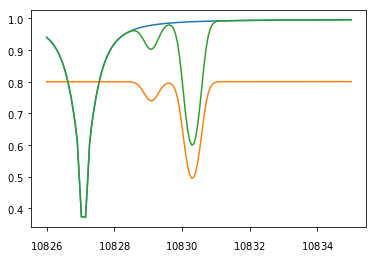

In [4]:
synthesize(theta=0.0, boundaryI=0.8)

The reason for that is that a chromosphere is modeled in Hazel as a slab and, therefore, one needs to give the Stokes profiles that are entering the slab from below and there is no general way of inferring it from the observations. For this reason, Hazel just gives you the option to enter the boundary conditions as a parameter. Note that this is important in case you are inverting sunspots because you have to modify the boundary condition appropriately to define the darker regions.

## Away from disk center
Let us consider now what happens when we are not at disk center.

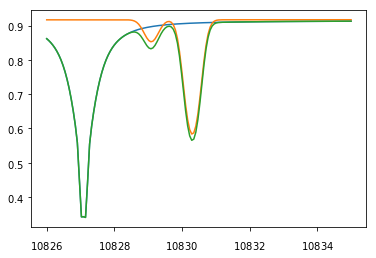

In [5]:
synthesize(theta=45)

As you see, the continuum is now smaller than one, and compatible with the center-to-limb variation in the quiet Sun:

In [8]:
mu = np.cos(45*np.pi/180)
clv = hazel.util.i0_allen(10830,mu) / hazel.util.i0_allen(10830,1.0)
print("CLV = {0}".format(clv))

CLV = 0.9167817591620029


For such an observation, in inversion mode, the observed profiles should be then normalized to the quiet Sun continuum at disk center. Equivalently, one can normalize to the quiet Sun in the observed map at the given heliocentric angle and then correct the profiles by the estimated CLV given above.

As a summary:

1. If you have a photosphere, just normalize the profiles to the continuum of the quiet Sun at disk center and the photosphere will adapt the temperature to produce the correct continuum.

2. If you only have chromospheres, then you need to define the appropriate boundary condition (in units of the quiet Sun continuum at disk center). Then, if you are dealing with sunspots or darker regions, you need to modify the boundary conditions appropriately to consider the darker continuum.